<a href="https://colab.research.google.com/github/ahmadmasood43/Glioblastoma-Detection-and-VR-Conversion/blob/main/testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [40]:
from PIL import Image
import os

# Path to the folder containing the images
folder_path = '/content/gdrive/MyDrive/brain_tumor_dataset/yes'

# Desired dimensions for the resized images
target_width = 224
target_height = 224

# Get the list of image filenames in the folder
image_filenames = os.listdir(folder_path)

# Iterate over the images and resize them
for image_filename in image_filenames:
    image_path = os.path.join(folder_path, image_filename)
    
    # Open the image using Pillow
    image = Image.open(image_path)
    
    # Resize the image
    resized_image = image.resize((target_width, target_height))
    
    # Save the resized image, overwriting the original image
    resized_image.save(image_path)
    
    print(f"Resized image saved: {image_path}")


Resized image saved: /content/gdrive/MyDrive/brain_tumor_dataset/yes/169 yes.jpg
Resized image saved: /content/gdrive/MyDrive/brain_tumor_dataset/yes/184 yes.jpg
Resized image saved: /content/gdrive/MyDrive/brain_tumor_dataset/yes/120 yes.jpg
Resized image saved: /content/gdrive/MyDrive/brain_tumor_dataset/yes/161 yes.jpg
Resized image saved: /content/gdrive/MyDrive/brain_tumor_dataset/yes/58 yes.jpg
Resized image saved: /content/gdrive/MyDrive/brain_tumor_dataset/yes/245 yes.jpg
Resized image saved: /content/gdrive/MyDrive/brain_tumor_dataset/yes/149 yes.jpg
Resized image saved: /content/gdrive/MyDrive/brain_tumor_dataset/yes/73 yes.jpg
Resized image saved: /content/gdrive/MyDrive/brain_tumor_dataset/yes/171 yes.jpg
Resized image saved: /content/gdrive/MyDrive/brain_tumor_dataset/yes/199 yes.jpg
Resized image saved: /content/gdrive/MyDrive/brain_tumor_dataset/yes/203 yes.jpg
Resized image saved: /content/gdrive/MyDrive/brain_tumor_dataset/yes/213 yes.jpg
Resized image saved: /content/

In [42]:
from PIL import Image
import os

# Path to the folder containing the resized images
folder_path = '/content/gdrive/MyDrive/brain_tumor_dataset/yes'

# Desired dimensions for the resized images
target_width = 224
target_height = 224

# Get the list of image filenames in the folder
image_filenames = os.listdir(folder_path)

# Iterate over the images and check their dimensions
for image_filename in image_filenames:
    image_path = os.path.join(folder_path, image_filename)
    
    # Open the image using Pillow
    image = Image.open(image_path)
    
    # Get the dimensions of the image
    width, height = image.size
    
    # Check if the image dimensions match the desired shape
    if width != target_width or height != target_height:
        print(f"Image not resized to desired shape: {image_filename}")
    else:
        print(f"Image resized correctly: {image_filename}")


Image resized correctly: 169 yes.jpg
Image resized correctly: 184 yes.jpg
Image resized correctly: 120 yes.jpg
Image resized correctly: 161 yes.jpg
Image resized correctly: 58 yes.jpg
Image resized correctly: 245 yes.jpg
Image resized correctly: 149 yes.jpg
Image resized correctly: 73 yes.jpg
Image resized correctly: 171 yes.jpg
Image resized correctly: 199 yes.jpg
Image resized correctly: 203 yes.jpg
Image resized correctly: 213 yes.jpg
Image resized correctly: 46 yes.jpg
Image resized correctly: 163 yes.jpg
Image resized correctly: 254 yes.jpg
Image resized correctly: 97 yes.jpg
Image resized correctly: 59 yes.jpg
Image resized correctly: 228 yes.jpg
Image resized correctly: 166 yes.jpg
Image resized correctly: 116 yes.jpg
Image resized correctly: 89 yes.jpg
Image resized correctly: 167 yes.jpg
Image resized correctly: 105 yes.jpg
Image resized correctly: 12 yes.jpg
Image resized correctly: 43 yes.jpg
Image resized correctly: 101 yes.jpg
Image resized correctly: 134 yes.jpg
Image res

In [ ]:
!apt-get install tree
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 0s (159 kB/s)
Selecting previously unselected package tree.
(Reading database ... 122532 files and directories currently installed.)
Preparing to unpack .../tree_1.8.0-1_amd64.deb ...
Unpacking tree (1.8.0-1) ...
Setting up tree (1.8.0-1) ...
Processing triggers for man-db (2.9.1-1) ...
.
├── gdrive
│   └── MyDrive
│       ├── 2d to 3d images
│       ├── AA
│       ├── annotations
│       ├── Audios from phone 04 2023
│       │   ├── Call recorded
│       │   └── no
│       ├── brain_test_data
│       ├── brain_tumor_dataset
│       │   ├── no
│       │   └── yes
│       

In [3]:
IMG_PATH = '/content/gdrive/MyDrive/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [4]:

def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [5]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  3.35it/s]
<ipython-input-4-59831cb31691>:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



439 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 46.82it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 38.37it/s]

111 images loaded from VAL/ directory.


In [6]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [7]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

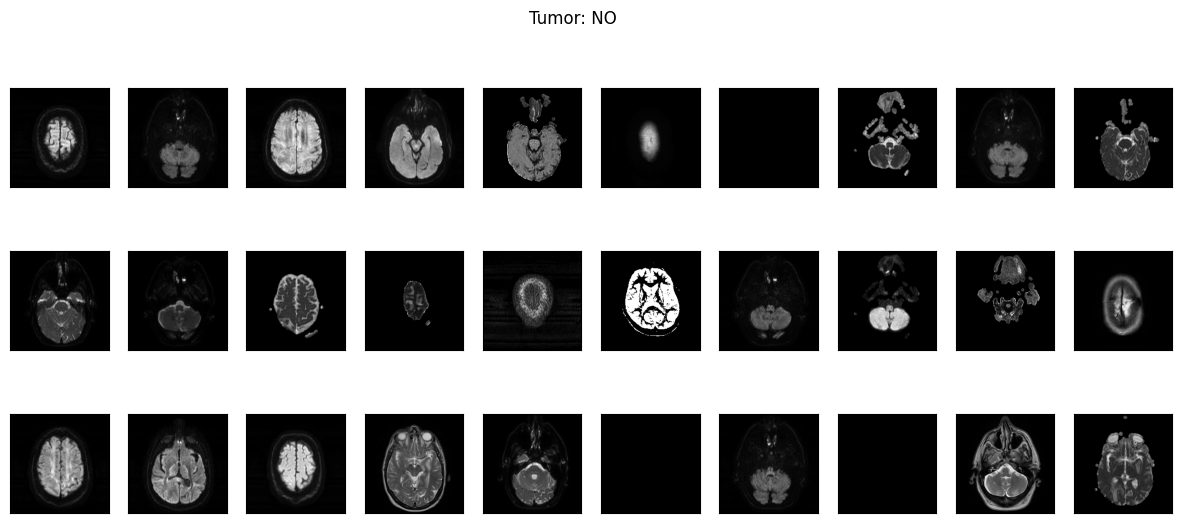

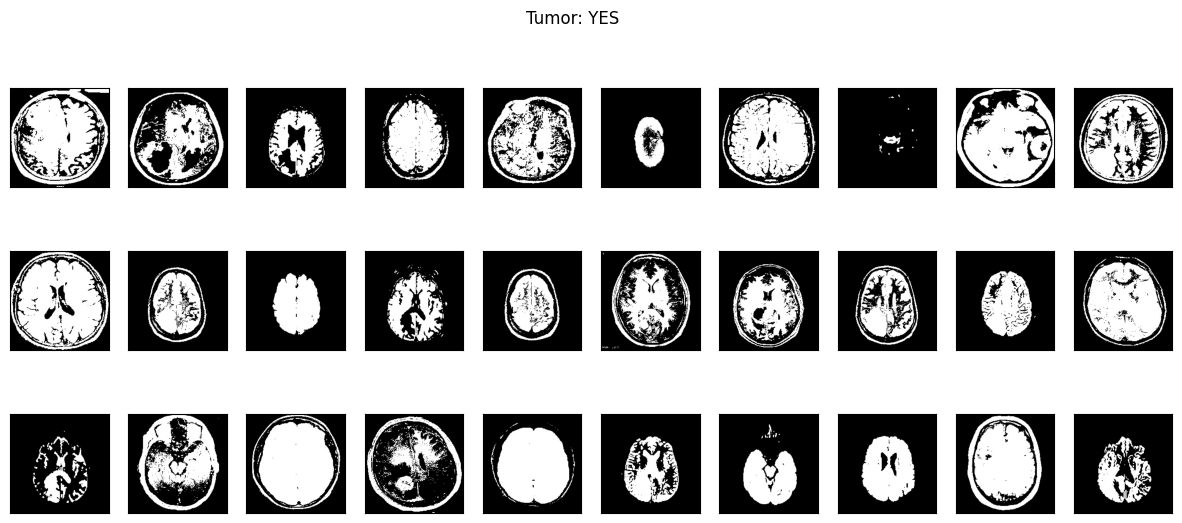

In [8]:
plot_samples(X_train, y_train, labels, 30)


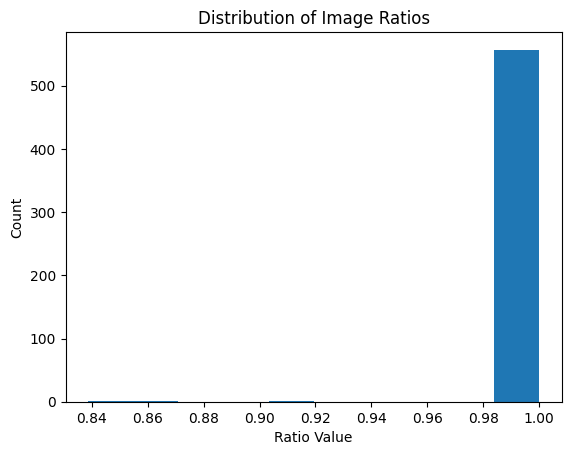

In [9]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [10]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [11]:
img = cv2.imread('/content/gdrive/MyDrive/brain_tumor_dataset/yes/1 yes.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()


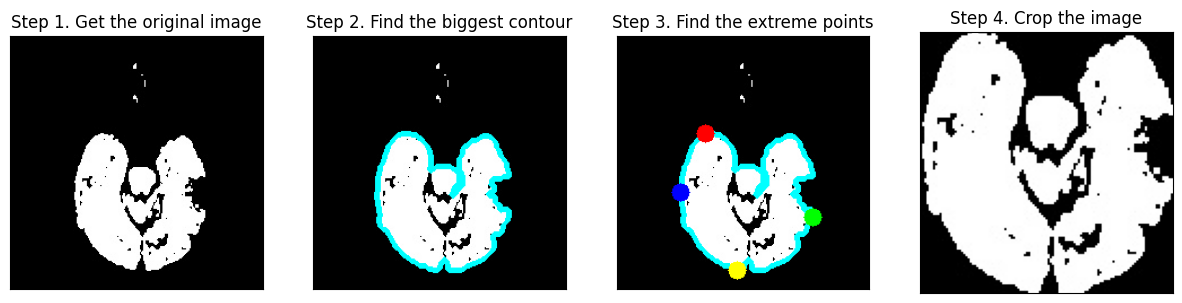

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the original image
img = cv2.imread('/content/gdrive/MyDrive/brain_tumor_dataset/yes/1 yes.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Perform necessary image processing steps to obtain img_cnt, img_pnt, and new_img

# Plot the images
plt.figure(figsize=(15, 6))

# Step 1: Get the original image
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')

# Step 2: Find the biggest contour
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')

# Step 3: Find the extreme points
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')

# Step 4: Crop the image
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')

plt.show()


In [13]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        if len(cnts) > 0:
            c = max(cnts, key=cv2.contourArea)

            # find the extreme points
            extLeft = tuple(c[c[:, :, 0].argmin()][0])
            extRight = tuple(c[c[:, :, 0].argmax()][0])
            extTop = tuple(c[c[:, :, 1].argmin()][0])
            extBot = tuple(c[c[:, :, 1].argmax()][0])

            ADD_PIXELS = add_pixels_value
            new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
            set_new.append(new_img)

    return np.array(set_new)

# Apply cropping to each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)


<ipython-input-13-a92036ca822b>:33: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [14]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


In [15]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [16]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [36]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

FileExistsError: ignored

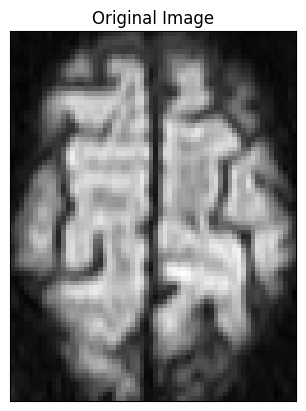

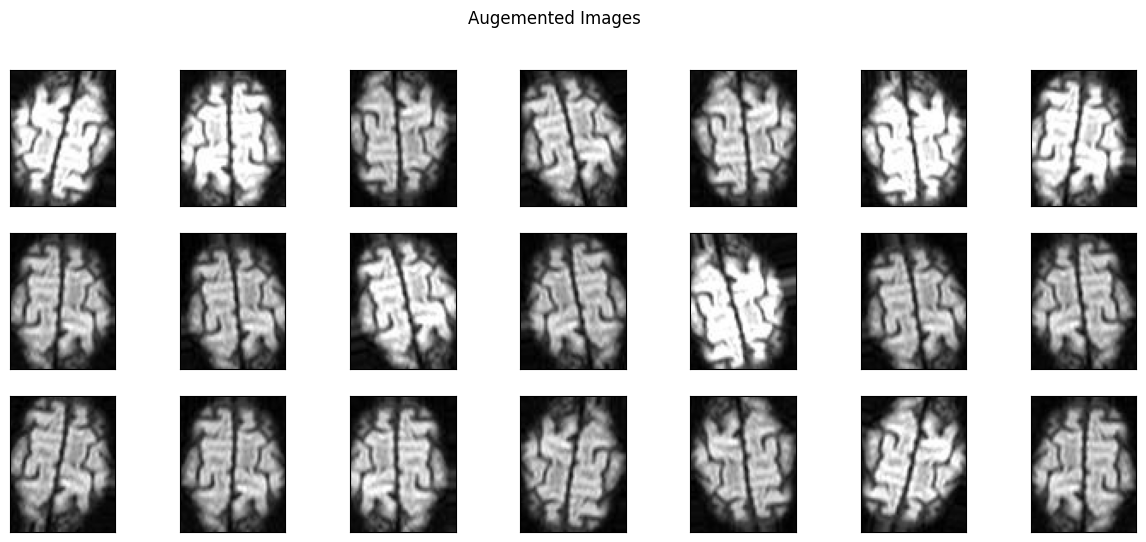

In [18]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [19]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 429 images belonging to 2 classes.
Found 111 images belonging to 2 classes.


In [23]:
from keras.applications import vgg16


img_rows, img_cols = 224, 224 


vgg = vgg16.VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

for layer in vgg.layers[:14]:
    layer.trainable = False
for layer in vgg.layers[15:17]:
    layer.trainable = False    
# Let's print our layers 
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D True
15 Conv2D False
16 Conv2D False
17 Conv2D True
18 MaxPooling2D True


In [24]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model 

In [25]:
from tensorflow.keras.models import Model

NUM_CLASSES = 1

model = Sequential()
model.add(vgg)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
#from tensorflow.keras.models import Model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
EPOCHS = 5
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

<ipython-input-37-d6bbe459f767>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/5
10/10 [==============================] - ETA: 0s - loss: 1.3704 - accuracy: 0.9037 

10/10 [==============================] - 167s 17s/step - loss: 1.3704 - accuracy: 0.9037 - val_loss: 14.4992 - val_accuracy: 0.4595
Epoch 2/5
10/10 [==============================] - ETA: 0s - loss: 1.1495 - accuracy: 0.8804 

10/10 [==============================] - 120s 13s/step - loss: 1.1495 - accuracy: 0.8804
Epoch 3/5
10/10 [==============================] - ETA: 0s - loss: 0.8723 - accuracy: 0.9003 

10/10 [==============================] - 122s 12s/step - loss: 0.8723 - accuracy: 0.9003
Epoch 4/5
10/10 [==============================] - ETA: 0s - loss: 1.1704 - accuracy: 0.8937 

10/10 [==============================] - 120s 12s/step - loss: 1.1704 - accuracy: 0.8937
Epoch 5/5
10/10 [==============================] - ETA: 0s - loss: 0.9025 - accuracy: 0.9070 

10/10 [==============================] - 120s 12s/step - loss: 0.9025 - accuracy: 0.9070


In [35]:
import os
import cv2
import numpy as np

# Path to the folder containing the images for testing
test_folder = '/content/gdrive/MyDrive/brain_tumor_dataset/testing'

# Get the list of image filenames in the test folder
image_filenames = os.listdir(test_folder)

# Iterate over the images and perform predictions
for image_filename in image_filenames:
    image_path = os.path.join(test_folder, image_filename)
    
    # Load the image
    try:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB if necessary
        image = cv2.resize(image, (image_width, image_height))  # Resize the image to match the input size of your model
    except Exception as e:
        print(f"Error processing image '{image_filename}': {str(e)}")
        continue
    
    # Preprocess the image
    try:
        # Perform any additional preprocessing steps here if required
        
        # Normalize the image pixel values to [0, 1]
        image = image / 255.0
        
        # Reshape the image to match the input shape expected by the model
        image = np.expand_dims(image, axis=0)
    except Exception as e:
        print(f"Error preprocessing image '{image_filename}': {str(e)}")
        continue
    
    # Perform prediction using the model
    try:
        predictions = model.predict(image)
        
        # Get the predicted class (assuming single-label classification)
        predicted_class = np.argmax(predictions)
        
        # Print the predicted class or perform any further processing
        
        # Example: Printing the filename and predicted class
        print(f"Image: {image_filename}, Predicted Class: {predicted_class}")
    except Exception as e:
        print(f"Error predicting image '{image_filename}': {str(e)}")


1/1 [==============================] - 1s 537ms/step
Image: 1-21.png, Predicted Class: 0
1/1 [==============================] - 1s 515ms/step
Image: 1-22.png, Predicted Class: 0
1/1 [==============================] - 0s 375ms/step
Image: 1-23.png, Predicted Class: 0
1/1 [==============================] - 0s 387ms/step
Image: 1-24.png, Predicted Class: 0
1/1 [==============================] - 0s 383ms/step
Image: 1-25.png, Predicted Class: 0
1/1 [==============================] - 0s 371ms/step
Image: 1-26.png, Predicted Class: 0
1/1 [==============================] - 0s 404ms/step
Image: 1-27.png, Predicted Class: 0
1/1 [==============================] - 0s 388ms/step
Image: 1-28.png, Predicted Class: 0
1/1 [==============================] - 0s 371ms/step
Image: 1-01.png, Predicted Class: 0
1/1 [==============================] - 0s 384ms/step
Image: 1-02.png, Predicted Class: 0
1/1 [==============================] - 0s 376ms/step
Image: 1-04.png, Predicted Class: 0
1/1 [================